# Purpose: Finding the image registration points for the fixed image (the universal atlas)

*Step 1: Importing necessary packages*

In [8]:
# operating system dependent functionality
import os

#allows for all the pathnames of a specified pattern to be located
from glob import glob

#Package imports
import numpy as np
from PIL import Image
import nibabel as nib
import nrrd
import pandas as pd
from skimage import io
import cv2
from skimage import filters
import pandas as pd

import matplotlib.pyplot as plt

import ifmodels.register as register

%matplotlib inline

*User Defined Variables*

In [9]:
file = '/Users/HawleyHelm/Desktop/packages/image-registration/Dawley-p14/NITRC-dti_rat_atlas-Downloads/atlas_segmentation.nrrd'

*Step 2: Importing the universal atlas and converting to a .nii file*

In [10]:
F_im_nii = register.nrrd_to_nii(file)

*Step 3: Extracting individual slices from the atlas*

In [11]:
#Input is the atlas file name, coronal slice number (no current inputs for sagittal or horizontal slices)
slices = register.atlas_slice(F_im_nii, 130)

*Step 4: Showing the slices*

In [12]:
type(slices)

tuple

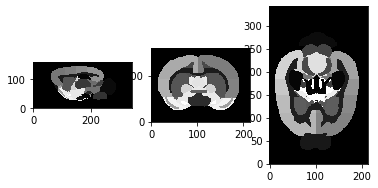

In [9]:
register.show_slices(slices)

*Step 5: Grabbing and viewing an individual slice*

In [10]:
#Defining each slice to an indvidual view

In [12]:
saggital = slices[0]
coronal = slices[1]
horizontal = slices[2]

In [13]:
F_im = coronal.astype(np.uint16) #converting to numpy array same type as our images

In [14]:
#Showing the slice for verification (note that it has rotated from above) 

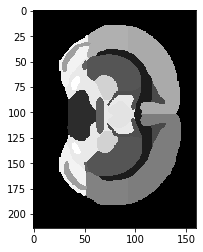

In [15]:
plt.imshow(F_im, cmap='gray')

*Step 6: Resizing the atlas so that I don't lose quality of our images when registering*

In [16]:
scale_percent = 20 # percent of original size
width = int(F_im.shape[1] * scale_percent)
height = int(F_im.shape[0] * scale_percent)
dim = (width, height)
# resize image
resized = cv2.resize(F_im, dim, interpolation = cv2.INTER_AREA)

In [17]:
#Showing the image to check the axes values

In [18]:
resized.shape

(4280, 3200)

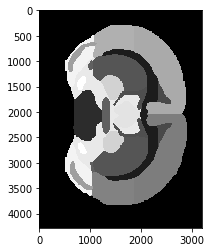

In [19]:
plt.imshow(resized, cmap='gray')
#checking the axis values now

*Finding the image registration points*

*Step a: Finding the edges of the sections*

In [20]:
gauss = filters.gaussian(resized, sigma=11, output=None, mode='nearest', cval=0, multichannel=None, preserve_range=False, truncate=4.0)

In [21]:
edge_sobel = filters.sobel(gauss)

In [22]:
threshold = filters.threshold_otsu(edge_sobel)
binary = edge_sobel > threshold

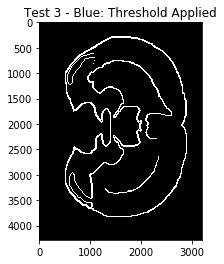

In [23]:
plt.imshow(binary, cmap = 'gray')
plt.title('Test 3 - Blue: Threshold Applied')

plt.show()

In [24]:
#Functions for Finding the Local Max point Coordinates

In [25]:
def point_x_value(binary_image):
    #Trying to find the relative maximum at the top of the slice in a new way
    for x in range(binary_image.shape[0]):
        unique_array = np.unique(binary_image[x], axis=0)
        if unique_array.shape[0] == 2:
            break
    return x

In [26]:
def point_y_values(binary_image):
    x = point_x_value(binary_image)
    y_list = []
    for y in range(binary_image[x].size):
        image = binary_image[x]
        value = image[y]
        if value == True:
            y_list.append (y)
        else:
            pass
    y_list = np.array(y_list)
    return y_list

In [27]:
def point_middle(binary_image):
    y = point_y_values(binary_image)
    middle = np.median(y)
    midpoint = int(middle)
    return midpoint

In [28]:
def local_max(binary_image):
    x = point_x_value(binary_image)
    y = point_middle(binary_image)
    return x, y

In [29]:
#Finds a local min instead of local max

In [30]:
def min_x_value(binary_image):
    #Trying to find the relative maximum at the top of the slice in a new way
    xlist = reversed(range(binary_image.shape[0]))
    for x in xlist:
        unique_array = np.unique(binary_image[x], axis=0)
        if unique_array.shape[0] == 2:
            break
    return x

In [31]:
def point_ymin_values(binary_image):
    x = min_x_value(binary_image)
    y_list = []
    for y in range(binary_image[x].size):
        image = binary_image[x]
        value = image[y]
        if value == True:
            y_list.append (y)
        else:
            pass
    y_list = np.array(y_list)
    return y_list

In [32]:
def point_middle_min(binary_image):
    y = point_ymin_values(binary_image)
    middle = np.median(y)
    midpoint = int(middle)
    return midpoint

In [33]:
def local_min(binary_image):
    x = min_x_value(binary_image)
    y = point_middle_min(binary_image)
    return x, y

*Splitting the atlas to get the final four points*

In [34]:
binary_half = np.split(binary, 2)

In [35]:
left1 = binary_half[0]

In [36]:
left1 = np.rot90(left1, k=1)

In [37]:
left2 = binary_half[1]

In [38]:
left2 = np.rot90(left2, k=1)

*Viewing these points on the atlas*

In [39]:
binaryx, binaryy = binary.shape

In [40]:
lx,ly = left1.shape

In [41]:
x1, y1 = local_max(binary)
x4, y4 = local_min(binary)
sy2, x2 = local_max(left1)
sy6, x6 = local_min(left1)
sy3, sx3 = local_max(left2)
sy5, sx5 = local_min(left2)

In [42]:
#Need to create a function that makes the red points around our points

In [43]:
def red_points(checkx, checky):
    checkpoints [checkx, checky] = 255
    kernel = list(range(1,50))
    xvalues = list(range(checkx - 50, checkx+50))
    for x in xvalues: 
        for distances in kernel:
            checkpoints[x, (checky - distances):(checky+distances), 0:1] = 255
    return

In [44]:
#Getting the points used for actual image registration and plotting them as a check

In [45]:
checkpoints = np.zeros([4280,3200, 3], dtype=np.uint8) #Shape of binary with rgb levels

y2 = binaryy - sy2
y6 = (binaryy - sy6)
x5 = sx5 + ly
y5 = (binaryy-sy5)
x3 = sx3 + ly
y3 = (binaryy - sy3)


red_points(x1, y1)
red_points(x4, y4)
red_points(x2, y2)
red_points(x6, y6)
red_points(x5, y5)
red_points(x3, y3)

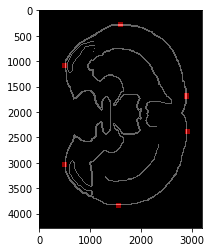

In [46]:
plt.imshow(binary, cmap='gray')
plt.imshow(checkpoints, alpha=0.6)

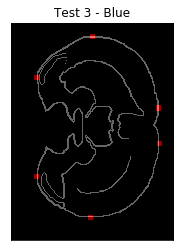

In [47]:
fig = plt.figure()
plt.imshow(binary, cmap = 'gray')
plt.imshow(checkpoints, alpha=0.6)
plt.title('Test 3 - Blue')
plt.xticks([])
plt.yticks([])

plt.show()
fig.savefig('Fixed-Image.png', bbox_inches='tight')

In [48]:
#Creating a pandas dataframe that has the coordinates for the individual points

In [49]:
coor = {'F_x': [x1, x2, x3, x4, x5, x6], 'F_y': [y1, y2, y3, y4, y5, y6]}

In [50]:
df = pd. DataFrame(coor, columns = ['F_x', 'F_y'])
df

,F_x,F_y
0,283,1609
1,1689,2896
2,2389,2914
3,3833,1569
4,3029,502
5,1089,502


In [51]:
export_csv = df.to_csv('/Volumes/imagereg/6-26-19-tiffexport/F_regPoints_csv', index = None)

FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/imagereg/6-26-19-tiffexport/F_regPoints_csv'